# 4. Operating a fleet of aircrafts with RL: multi-agent RL and independent Q-learning (IQL)

In this notebook 

#### To install

To install the necessary python libraries, open the Anaconda Prompt, drive to the directory where the `environment.yml` file is and run the following command:

`conda env create -f environment.yml -n rlenv`

This will create a virtual environment with all the required packages (tensorflow, pytorch, gym etc...). Then activate the environment with `conda activate rlenv`.
#### Initial settings

In [21]:
%load_ext autoreload
%autoreload 2

# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime, timedelta
import random
from collections import deque
import time
import copy
import json
import itertools
import shutil
import matplotlib.patches as mpatches
# Pytorch
import torch
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

# setting device on GPU if available, else CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:',device)
# print(torch.cuda.get_device_name(0))

# plotting parameters
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# import environment module
import opfleet_env as opfleet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load environment

Create a 1-aircraft fleet environment with the following parameters:
- 2 mission types (M1 and M5)
- 1 mission prescribed each day, randomly chosen amongst the two mission types
- lifetime of 5 years (2018-2023)
- reward of +1 for M1 and +2 for M5
- penalty of -10 for preventive maintenance and -100 for corrective maintenance and 5 timesteps of waiting period in both cases
- crack length discretised in 10 levels

In [15]:
run_name = 'example_test_DQN'
# create folder to store the outputs 
fp_outputs = os.path.join(os.getcwd(),run_name)
if not os.path.exists(fp_outputs): os.makedirs(fp_outputs)

params = {

    # Paris law parameters for degradation model
    'b': 76.2/1000,         # body width converted to metres
    'm': 2.9,               # Paris exponent
    'C_median': 8.586e-11+2*0.619e-11,  # median of Paris coefficient C
    'C_std': 3*0.619e-11,     # std of Paris coefficient C 

    # initial and critical crack length
     'a0': 9/1000,          # 9mm as in Virkler data converted to metres
     'amax': (76.2/2)/1000, # critical at one third of body width

    # assume that cyclic stress frequency is 0.65 Hz (20Hz in Virkler data)
    'f0': 5,

    # assume that different maneuvers have different stress range (ds)
    # maneuver m1: ds = 30 MPa (level fly), ds = stress range/amplitude
    # maneuver m2: ds = 50 MPa (take-off & land), ds=48.26 in Virkler data
    # maneuver m3: ds = 70 MPa (barrel rotate)
    # maneuver m4: ds = 90 MPa (pull up/down & turn)
    # maneuver m5: ds = 110 MPa (vertical up/down)
    'maneuvers': [30, 50, 70, 90, 110], # ds for each maneuver

    # define 5 types of missions, where different maneuvers are performed
    # Mission  #1: m1(3600sec) - m2(60sec) - m3(40sec) - m4(60sec) - m5(20sec)
    # Mission  #2: m1(4000sec) - m2(60sec) - m3(60sec) - m4(80sec)
    # Mission  #3: m1(3000sec) - m2(60sec) -             m4(70sec) - m5(40sec)
    # Mission  #4: m1(2600sec) - m2(60sec) - m3(30sec) -             m5(10sec)
    # Mission  #5: m1(4500sec) - m2(60sec) -             m4(60sec) - m5(80sec)
    # duration in s:      M1, M2, M3, M4, M5
    'missions': {'M1': [2600, 60, 30, 0 , 10],
                 'M5': [4500, 60, 0 , 60, 80]},    

    # fleet composition
    'n_tail': 1, 

    # episode timeframe (Monday to Friday)
    'date_start': datetime(2018,1,1),   # starting date
    'date_end': datetime(2023,1,1),     # ending date

    # prescribed missions, number of daily missions and composition
    'missions_per_day': 1,              # how many missions are prescribed each day
    'mission_composition': 'fixed-mixed',  # 3 options for the mission composition:
                                        # 'fixed-constant': fixed number of mission and constant composition (e.g., one of each)
                                        # 'fixed-constant-random': if more missions than mission types, chooses the extra missions randomly
                                        # 'fixed-mixed': fixed number of missions but random composition  
                                        # 'random': random number of missions and random composition 
                                        # 'custom': provide a mission composition that is repeated for every day

    # reward function [-1 per day in maintenance, 0 standby]
    'reward_scheme': 'mission-based', # 3 implemented reward schemes
                                 # 'constant': constant reward [+1 per mission flown]
                                 # 'damage-based': reward based on damage caused
                                 # 'mission-based': reward based on mission type
    # if 'mission-based', specify the rewards
    'reward_per_mission': [1,2], # respective rewards for [M1,M2,M3,M4,M5]

    # maintenance levels      duration repair   cost
    'preventive_maintenance': [5,      30,     10],
    'corrective_maintenance': [5,     30,      100],

    # crack length discretation
    'damage_levels': 10,
    
    }
# randomly draw C-values
params['C'] = params['C_median'] + params['C_std']*np.random.normal(size=params['n_tail'])
# save params into a file
with open(os.path.join(fp_outputs,'params.pkl'),'wb') as f:
    pickle.dump(params,f)
    
print(params)

{'b': 0.0762, 'm': 2.9, 'C_median': 9.824e-11, 'C_std': 1.857e-11, 'a0': 0.009, 'amax': 0.0381, 'f0': 5, 'maneuvers': [30, 50, 70, 90, 110], 'missions': {'M1': [2600, 60, 30, 0, 10], 'M5': [4500, 60, 0, 60, 80]}, 'n_tail': 1, 'date_start': datetime.datetime(2018, 1, 1, 0, 0), 'date_end': datetime.datetime(2023, 1, 1, 0, 0), 'missions_per_day': 1, 'mission_composition': 'fixed-mixed', 'reward_scheme': 'mission-based', 'reward_per_mission': [1, 2], 'preventive_maintenance': [5, 30, 10], 'corrective_maintenance': [5, 30, 100], 'damage_levels': 10, 'C': array([8.88892767e-11])}


1305 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 1
Number of actions per tail number: 4
['M1', 'M5', 'SB', 'MT']
Mission mode: fixed-mixed
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 4
Number of possible states: 9


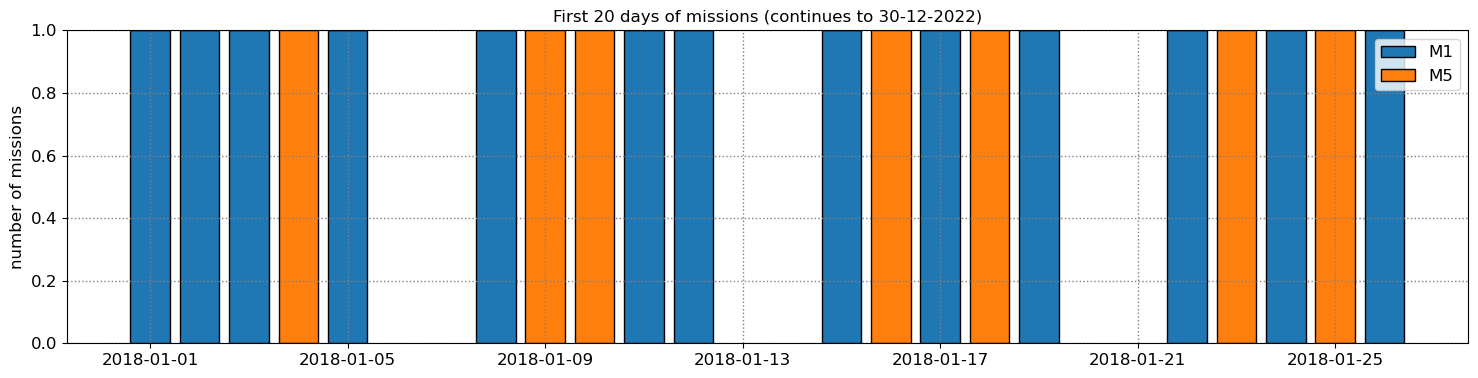

In [16]:
# create the opfleet Env class (contains all the logic to manage the fleet)
env = opfleet.Env(params, verbose=True)

Note that this is a very small environment, with only 9 possible states and 4 possible actions. It is ideal to test the DQN methodology and make sure that everything is working correctly.

## 2. Policy Optimisation with standard Q-learning

First we look for the optimal policy using standard Q-learning with a look-up table.

First, we define the search parameters:
- `epsilon`: exploration rate, usually starts at 1 (always random actions) and the decays exponentially during the search
- `alpha`: learning rate, usually starts at 1 and the decays exponentially during the search
- `gamma`: discount factor between 0 and 1, determines how far in the future the agent considers rewards, default 0.9

1305 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 1
Number of actions per tail number: 4
['M1', 'M5', 'SB', 'MT']
Mission mode: fixed-mixed
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 4
Number of possible states: 9


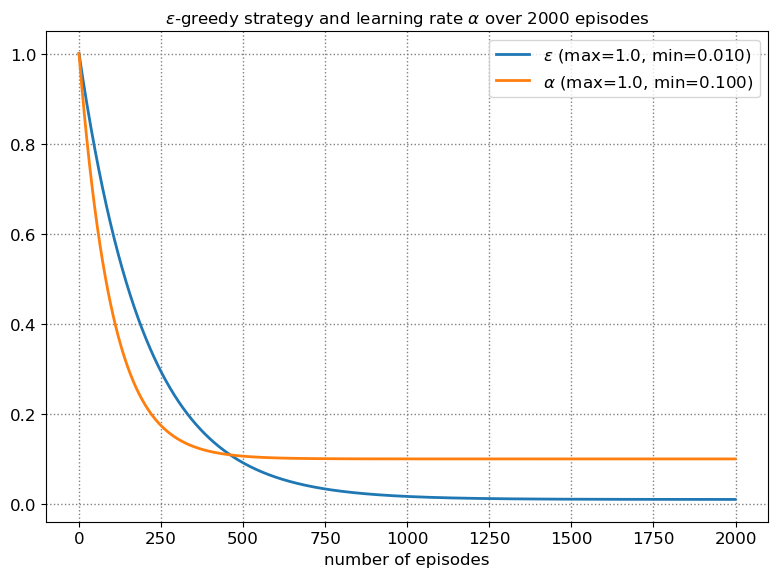

In [17]:
fp = os.path.join(fp_outputs,'Qtable_run1')
if not os.path.exists(fp): os.makedirs(fp)

# training parameters
train_params = {
    'n_episodes': 2000,        # number of episodes for the search
    'max_epsilon': 1,          # max epsilon at the start of the search
    'min_epsilon': 0.01,       # minimum exploration rate
    'decay_epsilon': 0.005,    # epsilon decay
    'max_alpha': 1,            # initial alpha value
    'min_alpha': 0.1,          # min alpha
    'decay_alpha': 0.01,       # alpha decay
    'gamma': 0.9,              # discount factor
    'saving_step': 10,         # how often to save the model
    'repetitions': 10          # number of repetitions with random initial conditions to evaluate the performance
}

# plot epsilon and alpha decay curves
fig, epsilons, alphas = opfleet.plot_eps_alpha(train_params)
fig.savefig(os.path.join(fp,'epsilon_greedy_search.jpg'))

# store parameters in a text file for reference
with open(os.path.join(fp,'train_params.txt'),'w') as f:
    json.dump(train_params,f,indent=4)
    
# initialise environment
env = opfleet.Env(params,True)
plt.gcf().savefig(os.path.join(fp,'mission_profile.jpg'))
plt.close(plt.gcf())

# draw initial states for each episode from a uniform distribution
nei = train_params['n_episodes']
crack_lengths = np.empty((nei,env.n_tail))
for k in range(env.n_tail):
    crack_lengths[:,k] = np.random.uniform(env.a0*1000,env.amax*1000,nei)
# uncomment for exponential distribution
# random_exp = stats.truncexpon(env.amax*1000,scale=10)
# for k in range(env.n_tail):
#     sampled_cracks = env.amax*1000-random_exp.rvs(nei)
#     sampled_cracks = sampled_cracks[sampled_cracks>=env.a0*1000]
#     crack_lengths[:,k] = np.random.choice(sampled_cracks,nei)
train_params['crack_lengths'] = crack_lengths

Then we can initialise the Q-table with random values between -5 and 5 and run the policy search

In [ ]:
# initialise environment
env = opfleet.Env(params)
# initialise Q-table with random values
q_table = dict([])
states = np.arange(1,10)
for s in states:     
    state = '[%d]'%(s)
    q_table[state] = np.random.uniform(-5,5,len(env.possible_actions))
# perform the search
q_table = opfleet.train_qtable(env,q_table,train_params,fp)

Now we can check that the policy search converged (total reward per episode reaching an assymptote) and that also the average number of maintenances per episode also remains constant, indicating that the maintenance scheduling policy is not changing any more.

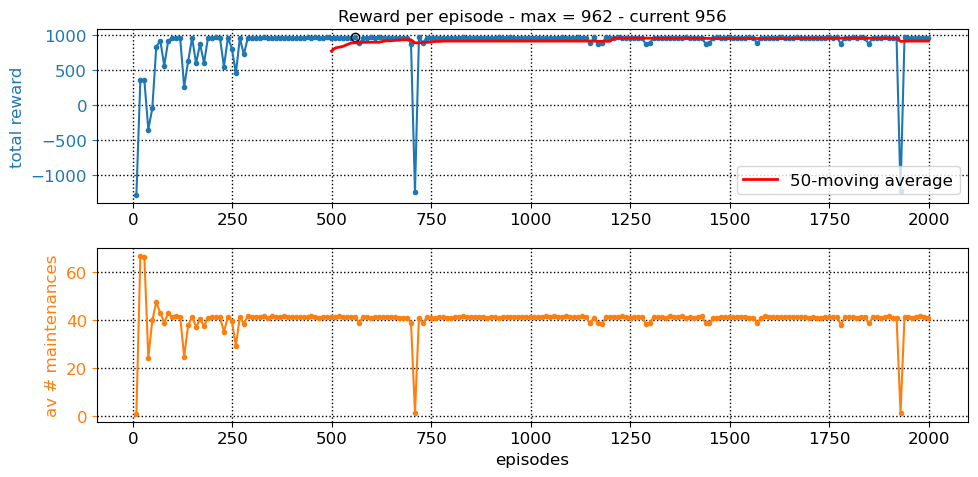

In [32]:
# load training parameters
with open(os.path.join(fp,'train_params.txt'),'r') as f:
    train_params = json.load(f)
step = train_params['saving_step']
n_episodes = train_params['n_episodes']
# load reward data
with open(os.path.join(fp,'train_stats.pkl'),'rb') as f:
    train_stats = pickle.load(f)
reward_per_episode = train_stats['reward']
maint_per_episode = train_stats['maint']
# plot reward time-series
fig = opfleet.plot_search_rewards(reward_per_episode,maint_per_episode,step,window=50)
fig.savefig(os.path.join(fp,'reward_per_episode.jpg'),dpi=200) 

Then we can load the best Q-table and run one 5-year episode. By plotting the dashboard of the episode we can see what the policy is doing, for example that preventive maintenace applied at damage levels 8 and 9. With 1-aircraft there aren't many degrees of freedom in the mission assignment, so it's mostly a maintenance schedling problem here.


qtable -> total rewards = 960


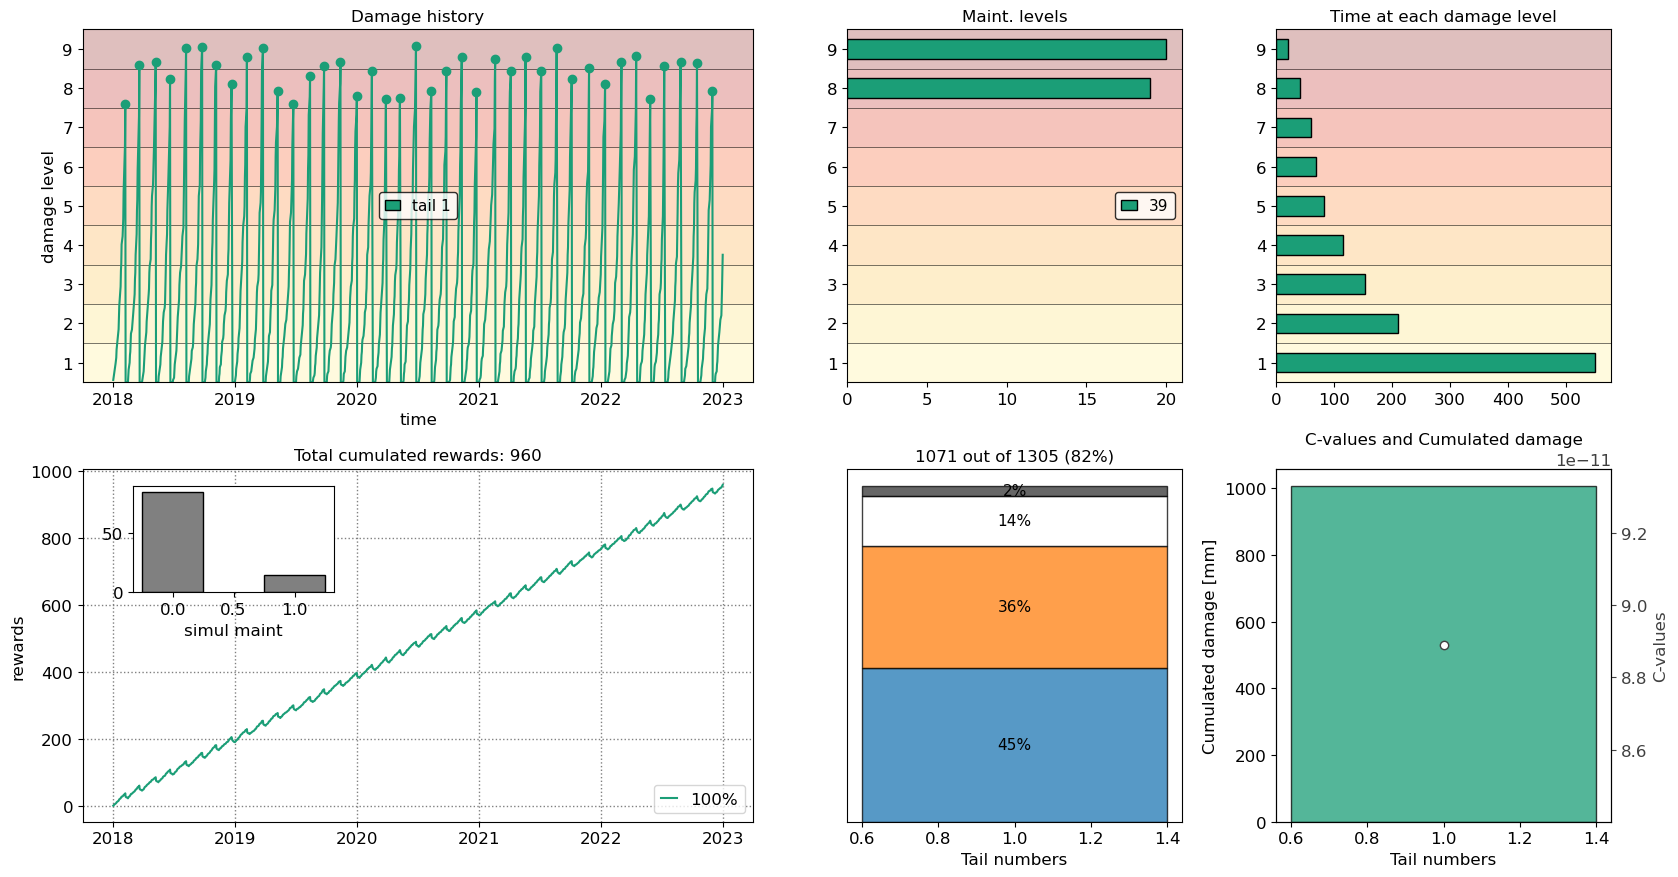

In [27]:
# load best Qtable
with open(os.path.join(fp,'qtable_best.pkl'),'rb') as f:
    q_table = pickle.load(f)
# run one episode with optimal Qtable
env.reset()
damage_ts, reward_ts, qvals = opfleet.episode_qtable(q_table,env)
print('qtable -> total rewards = %d'%np.nansum(reward_ts))
# plot time-series
fig = opfleet.plot_episode(damage_ts,reward_ts,env)

## 3. Policy optimisation with Deep Q-learning (DQN)

Now we will replace the look-up table with a neural network function approximator. The search parameters can stay the same, but we need to add additional parameters for updating the neural network. The update is done with a single back-propagation step using a batch of observations randomly sampled for the replay memory (just a circular buffer storing the state-action-reward-newstate tuple for each timestep). Additionally, we added the option to use double-Qlearning, where there is a second neural network that is updated at a lower frequency and only used for evaluation (not action selection) to help with convergence and remove a potential maximisation bias.

With these additions there are 6 new hyper-parameters:
- `hidden_layers`: architecture of the neural network (e.g., [36,16,8])
- `learning_rate`: learning rate for ADAM optimiser
- `update_freq`: frequency at which to update the model weights, every N observations
- `batch_size`: batch used to perform the back-propagation step
- `replay_size`: size of the circular replay buffer in which the observations are stored
- `double_QL`: whether to use double Q-learning or not
- `target_freq`: frequency at which to update the target model, every N updates of the main model


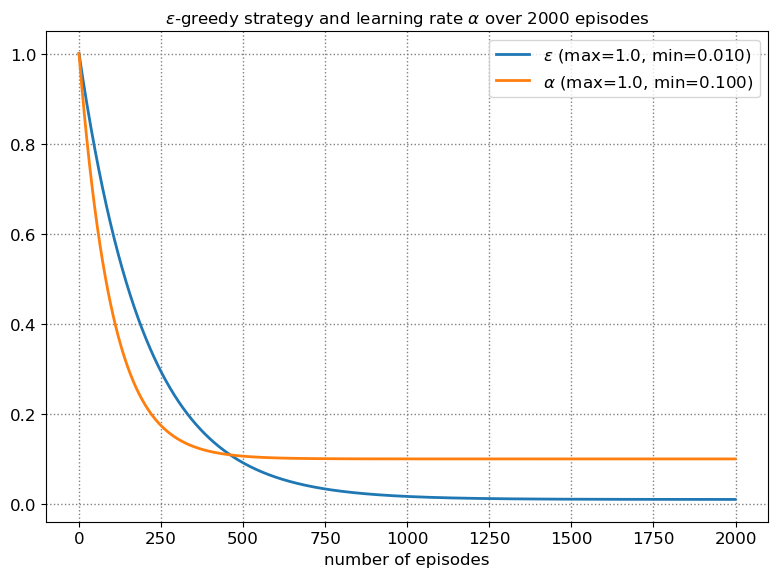

In [41]:
fp = os.path.join(fp_outputs,'DQN_run1')
if not os.path.exists(fp): os.makedirs(fp)

# training parameters
train_params = {
    'n_episodes': 2000,        # number of episodes for the search
    'max_epsilon': 1,          # max epsilon at the start of the search
    'min_epsilon': 0.01,       # minimum exploration rate
    'decay_epsilon': 0.005,    # epsilon decay
    'max_alpha': 1,            # initial alpha value
    'min_alpha': 0.1,          # min alpha
    'decay_alpha': 0.01,       # alpha decay
    'gamma': 0.9,              # discount factor
    'saving_step': 10,         # how often to save the model
    'repetitions': 10,         # number of repetitions with random initial conditions to evaluate the performance
    
    # Neural network parameters
    'hidden_layers': [32,16,8], # number of hidden layers and neurons per hidden layers for model
    'learning_rate': 0.001,     # learning rate (Adam)
    'update_freq': 50,          # model update frequency
    'batch_size': 16,           # size of batch use to update the model
    'replay_size': 5000,        # size of circular replay buffer
    'double_QL': True,          # whether to use double q-learning
    'target_freq': 20,          # frequency at which to update the target model
}

# plot epsilon and alpha decay curves
fig, epsilons, alphas = opfleet.plot_eps_alpha(train_params)
fig.savefig(os.path.join(fp,'epsilon_greedy_search.jpg'))

# store parameters in a text file for reference
with open(os.path.join(fp,'train_params.txt'),'w') as f:
    json.dump(train_params,f,indent=4)
    
# draw initial states for each episode from uniform distribution
nei = train_params['n_episodes']
crack_lengths = np.empty((nei,env.n_tail))
for k in range(env.n_tail):
    crack_lengths[:,k] = np.random.uniform(env.a0*1000,env.amax*1000,nei)
# uncomment to use exponential distribution
# random_exp = stats.truncexpon(env.amax*1000,scale=10)
# for k in range(env.n_tail):
#     sampled_cracks = env.amax*1000-random_exp.rvs(nei)
#     sampled_cracks = sampled_cracks[sampled_cracks>=env.a0*1000]
#     crack_lengths[:,k] = np.random.choice(sampled_cracks,nei)
train_params['crack_lengths'] = crack_lengths

Now we create the neural network model, print the summary and plot the weight and biases distribution

Net(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
  (criterion): MSELoss()
)


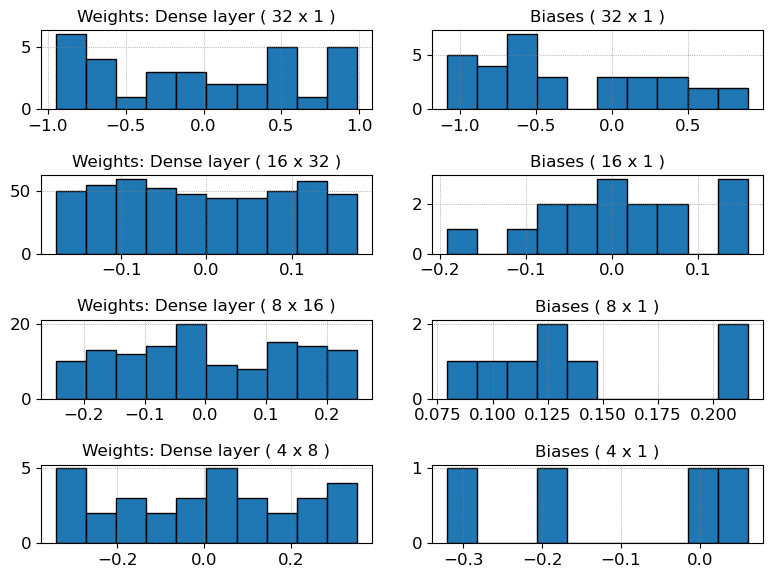

In [48]:
# create NN function approximator
input_dim = env.n_tail
output_dim = len(env.actions)
num_layers = len(train_params['hidden_layers'])
neurons_per_layer = train_params['hidden_layers']
lr = train_params['learning_rate']
model = opfleet.Net(num_layers,neurons_per_layer,input_dim,output_dim,lr)
print(model)
fig = opfleet.plot_agent(model)

With those initial weight and biases, the model just takes random actions. We can show this by running a 5-year episode.

It is best practice to initialise the model weights when using DQN, here we will show how the policy search performs first without iniitalisation and then with initialisation.

initial model -> total rewards = -1305


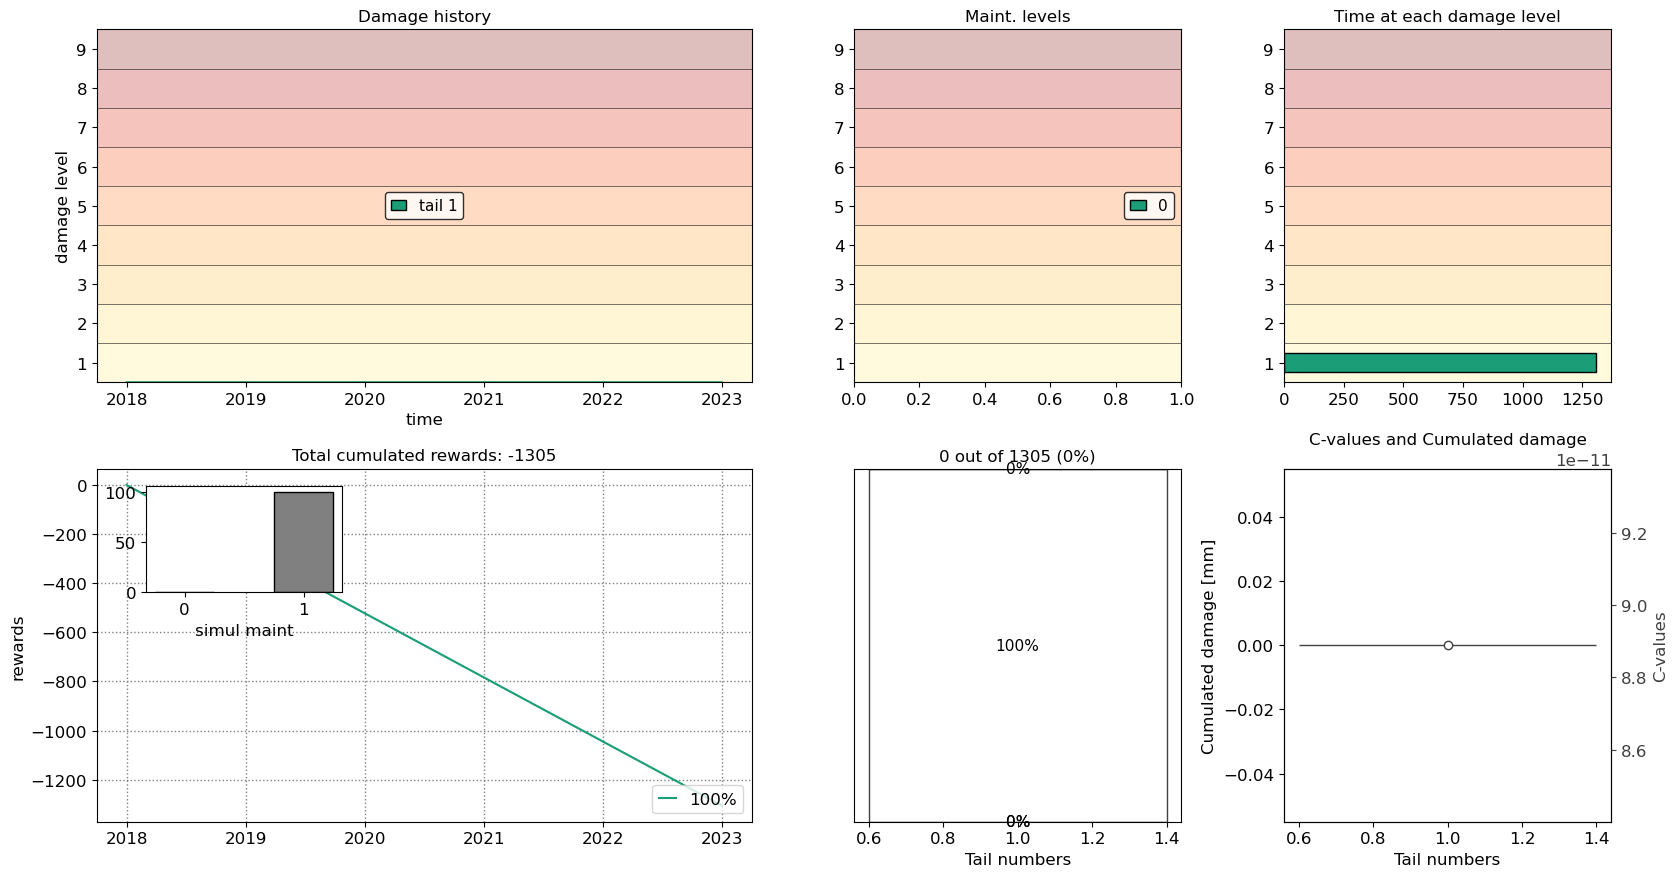

In [49]:
# run episode with random model
env.reset(True)
damage_ts, reward_ts, qvals = opfleet.episode_model(model,env)
print('initial model -> total rewards = %d'%np.nansum(reward_ts))
fig2 = opfleet.plot_episode(damage_ts,reward_ts,env)

Now we run the policy search using `train_DQNagent()`

Double Q-learning activated (update freq = 20)
2000 - rew 793 (best 961) - - eps 0.010 - alpha = 0.100001

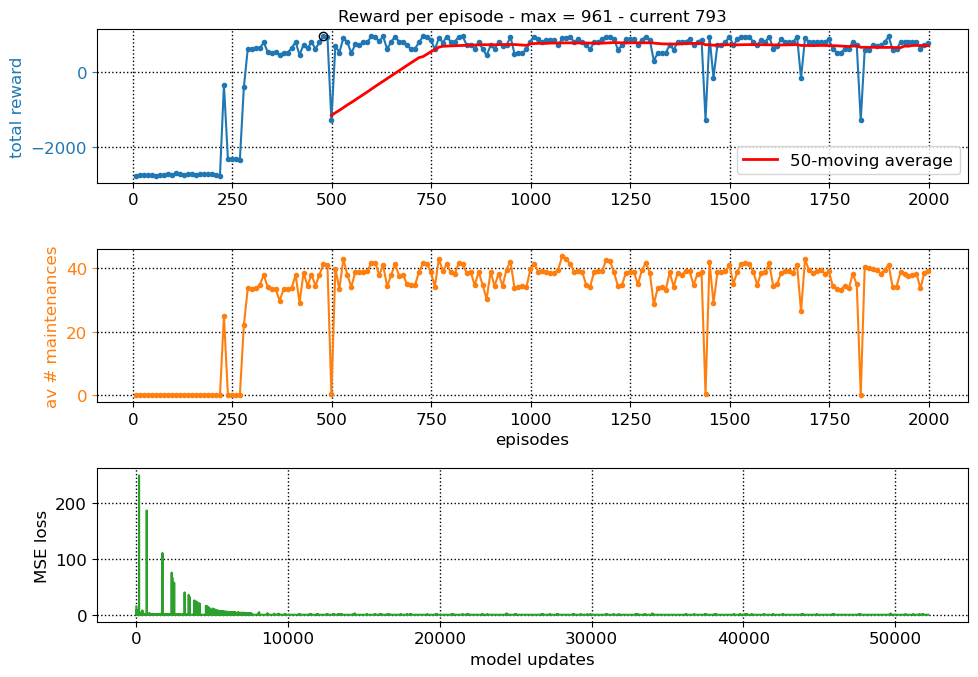

In [51]:
model = opfleet.train_DQNagent(env,params,model,train_params,fp)

We can see that the model converged, although the convergence is more noisy that for standard Q-learning (see plots above). The MSE loss function decreases during the search, however this behaviour is somehow forced by decaying the value of `alpha`.

If we look at the best-performing model, it looks very similar to the Q-table one.

qtable -> total rewards = 959


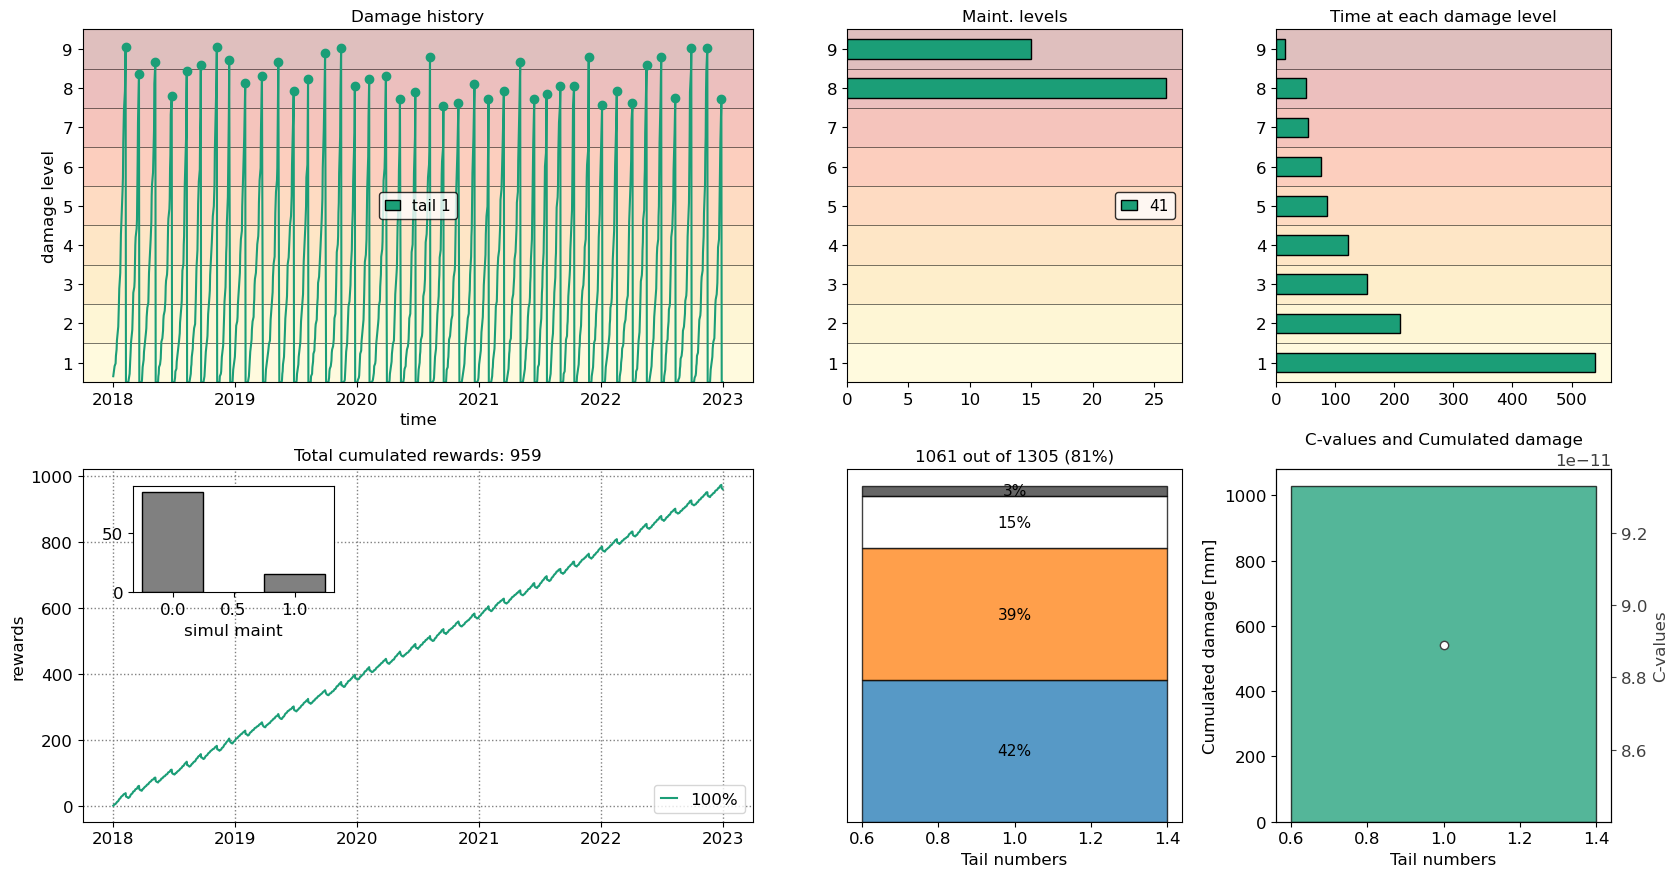

In [52]:
# load best moddl
model = torch.load(os.path.join(fp,'model_best.pkl'))
# run one episode with optimal Qtable
env.reset()
damage_ts, reward_ts, qvals = opfleet.episode_model(model,env)
print('qtable -> total rewards = %d'%np.nansum(reward_ts))
# plot time-series
fig = opfleet.plot_episode(damage_ts,reward_ts,env)

Now we evaluate the performance of the RL policies against the baseline strategies.

## 4. Comparison against baseline

With a single aircraft, the 3 baseline policies (on-condition maintenance, force-life management and equal-stress policy) are the same as there is only maintenance scheduling and no degrees of freedom for the mission assignment.

So we first find by trial-and-error the optimal maintenance threshold for the on-condition strategy. Then we run 10,000 episodes with each policy, the 2 RL policies and the on-condition maintenance, and we look at the distributions.

 running maintenance at level 9/10
Optimum maintenance level for on-condition policy: damage level of 8
Optimum maintenance level for force-life policy: damage level of 8
Optimum maintenance level for equal-stress policy: damage level of 8


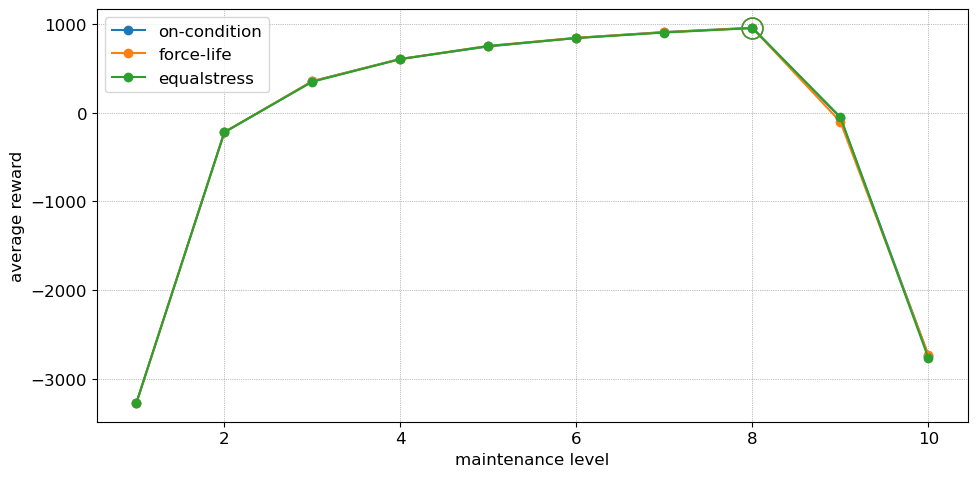

In [54]:
# find optimal maintenance threshold for each policy
level_oncond, level_forcelife, level_equalstress, fig  = opfleet.optimise_baselines(env,repetitions=10)

In [55]:
# load existing file if already ran the optimisation
fp_maintlevels = os.path.join(fp_outputs,'optimal_maintlevels.pkl')
if not os.path.exists(fp_maintlevels):
    maint_levels = {'level_oncond':level_oncond,'level_forcelife':level_forcelife,'level_equalstress':level_equalstress}
    with open(fp_maintlevels,'wb') as f:
        pickle.dump(maint_levels,f)
else:
    with open(fp_maintlevels,'rb') as f:
        maint_levels = pickle.load(f) 
print(maint_levels)

{'level_oncond': 8, 'level_forcelife': 8, 'level_equalstress': 8}


Then we used those maintenance levels to run N episodes with each policy, each episode is started in a randomised initial state.

In [56]:
# run N episodes with each policy
N = 1000
rewards_baselines = opfleet.run_episodes_baselines(env,maint_levels,N)

unning episode 1000/1000

In [66]:
# load existing file if it already exists
fp_baselines = os.path.join(fp_outputs,'reward_baselines.pkl')
if not os.path.exists(fp_baselines):
    with open(fp_baselines,'wb') as f:
        pickle.dump(rewards_baselines,f)
else:
    with open(fp_baselines,'rb') as f:
        rewards_baselines = pickle.load(f) 

Then we run N episodes with the RL policies and compare the distributions

In [ ]:
N = 1000
# run N episodes with qtable
rewards_qtable = opfleet.run_episodes_qtable(env,q_table,N)
# run N episodes with NN model
rewards_model = opfleet.run_episodes_model(env,model,N)

 running episode 1000/1000

In [60]:
# load existing file if it already exists
fp_RL = os.path.join(fp_outputs,'reward_RL_Qtable.pkl')
if not os.path.exists(fp_RL):
    with open(fp_RL,'wb') as f:
        pickle.dump(rewards_qtable,f)
else:
    with open(fp_RL,'rb') as f:
        rewards_qtable = pickle.load(f) 

In [61]:
# load existing file if it already exists
fp_RL = os.path.join(fp_outputs,'reward_RL_DQN.pkl')
if not os.path.exists(fp_RL):
    with open(fp_RL,'wb') as f:
        pickle.dump(rewards_model,f)
else:
    with open(fp_RL,'rb') as f:
        rewards_model = pickle.load(f) 

In [62]:
# add RL to rewards dictionary
rewards_baselines['RL_Qtable'] = rewards_qtable
rewards_baselines['RL_DQN'] = rewards_model

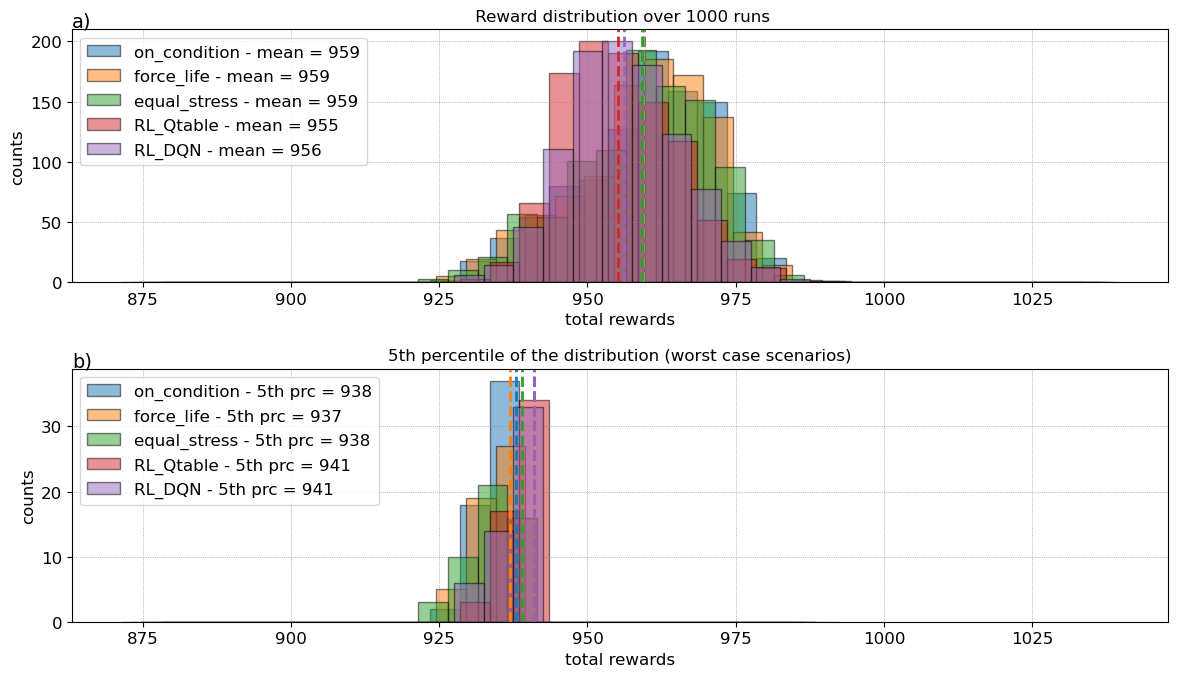

In [65]:
# plot reward distributions
fig = opfleet.plot_reward_distributions(rewards_baselines, binwidth=5)
fig.savefig(os.path.join(fp_outputs,'policy_evaluation.jpg'))

We can see that all policy perform similarly which means that both the Q-learning and DQN algorithms found good policies for the maintenance scheduling problem of 1 aircaft.

## 5. Concluding remarks

We have seen that for only 1 aircraft, the DQN is equivalent to the Q-table method, although it has 6 extra hyper-parameters for which adequate values need to be chosen (not always straight-forward). However, when we have tested this with multiple aircraft in the fleet, the DQN method was not able to find a high-performing policy, and instead converged to a policy where all aircraft in the fleet are instructed to always stand-by.

Having a model that runs for a single aircraft is very useful in the context of implementing multi-agent RL algorithms. In fact, many of the algorithms (like QMIX, https://arxiv.org/abs/1803.11485) use a DQN architecture where each agent is using a neural network. Therefore, the DQN example shown here can be used to assign one NN to each agent and integrate it into a multi-agent framework.